
In this notebook, You will do amazon review classification with BERT.[Download data from [this](https://www.kaggle.com/snap/amazon-fine-food-reviews/data) link]
<pre> 
It contains 5 parts as below.  Detailed instrctions are given in the each cell. please read every comment we have written. 
    1. Preprocessing 
    2. Creating a BERT model from the Tensorflow HUB.
    3. Tokenization
    4. getting the pretrained embedding Vector for a given review from the BERT.
    5. Using the embedding data apply NN and classify the reviews.
    6. Creating a Data pipeline for BERT Model. 

<font size=5>instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. 
    If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. please return outputs in the same format what we asked. Eg. Don't return List if we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>
</pre>

In [ ]:
#in this assignment you need two files reviews.csv and tokenization file
#you can use gdown module to import both the files in colab from Google drive
#the syntax is for gdown is !gdown --id file_id
#please run the below cell to import the required files


In [1]:
!gdown --id 1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
!gdown --id 13exfXiyiByluh1PfYK1EyZyizqxeCVG9

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1GsD8JlAc_0yJ-1151LNr6rLw83RRUPgt
To: /content/Reviews.csv
100% 301M/301M [00:03<00:00, 85.8MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=13exfXiyiByluh1PfYK1EyZyizqxeCVG9
To: /content/tokenization.py
100% 17.3k/17.3k [00:00<00:00, 27.2MB/s]


In [2]:
#all imports
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Model

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

<font size=4>Grader function 1 </font>

In [4]:
def grader_tf_version():
    assert((tf.__version__)>'2')
    return True
grader_tf_version()

True

<pre><font size=6>Part-1: Preprocessing</font></pre>

In [5]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv(r"Reviews.csv")
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [15]:
#get only 2 columns - Text, Score
#drop the NAN values
reviews = reviews[['Text','Score']]
reviews.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


Checking for null values - As can be observed from the below code there are no null values in the data.

In [16]:
reviews.isnull().apply(sum)

Text     0
Score    0
dtype: int64

In [17]:
#if score> 3, set score = 1
#if score<=2, set score = 0
#if score == 3, remove the rows.

def binary_conversion(x):
  if x > 3:
    return 1
  elif x<=2:
    return 0
  return None

reviews['Score'] = reviews['Score'].apply(binary_conversion)
reviews.head()  

,Text,Score
0,I have bought several of the Vitality canned d...,1.0
1,Product arrived labeled as Jumbo Salted Peanut...,0.0
2,This is a confection that has been around a fe...,1.0
3,If you are looking for the secret ingredient i...,0.0
4,Great taffy at a great price. There was a wid...,1.0


In [18]:
sum(reviews.Score.isnull())

42640

In [19]:
reviews.dropna(inplace = True)
print(reviews.shape)

(525814, 2)


<font size=4>Grader function 2 </font>

In [20]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1]==443777)
    assert(temp_shape == True)
    return True
grader_reviews()

True

In [21]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews = reviews.sample(n=100000, random_state=30)

In [22]:
#remove HTML from the Text column and save in the Text column only
import re
def remove_html(x):
  return re.sub("<.*?>", '', x)

reviews['Text'] = reviews['Text'].apply(remove_html)

In [23]:
#print head 5
print(reviews.head(5))

                                                     Text  Score  len
64117   The tea was of great quality and it tasted lik...    1.0   30
418112  My cat loves this.  The pellets are nice and s...    1.0   31
357829  Great product. Does not completely get rid of ...    1.0   41
175872  This gum is my favorite!  I would advise every...    1.0   27
178716  I also found out about this product because of...    1.0   22


In [25]:
#split the data into train and test data(20%) with Stratify sampling, random state 33
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews['Text'], reviews['Score'], test_size = 0.2, stratify = reviews['Score'], 
                                                    random_state = 33)

In [33]:
vals_tr = y_train.value_counts()
vals_te = y_test.value_counts()

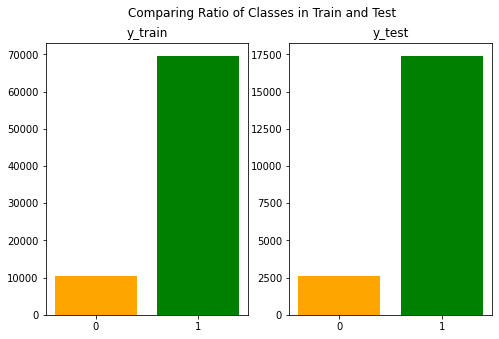

In [44]:
#plot bar graphs of y_train and y_test
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(8)
fig.suptitle('Comparing Ratio of Classes in Train and Test')
ax1.bar(vals_tr.index, vals_tr.values, color = ['green', 'orange'])
ax1.set_title("y_train")
ax1.set_xticks([0, 1])
ax2.bar(vals_te.index, vals_te.values, color = ['green', 'orange'])
ax2.set_title("y_test")
ax2.set_xticks([0, 1])
plt.show()

In [45]:
#saving to disk. if we need, we can load preprocessed data directly. 
reviews.to_csv('preprocessed.csv', index=False)

<pre><font size=6>Part-2: Creating BERT Model</font> 

If you want to know more about BERT, You can watch live sessions on Transformers and BERt. 
we will strongly recommend you to read <a href="https://jalammar.github.io/illustrated-transformer/">Transformers</a>, <a href="https://arxiv.org/abs/1810.04805">BERT Paper</a> and, <a href="https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/">This blog</a>.


For this assignment, we are using <a href="https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1">BERT uncased Base model</a>. 
It uses L=12 hidden layers (i.e., Transformer blocks), a hidden size of H=768, and A=12 attention heads. </pre>

In [46]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55. You can change this
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [47]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [48]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

<pre><font size=6>Part-3: Tokenization</font></pre>

In [49]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [55]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.3 MB/s 


In [56]:
import tokenization #We have given tokenization.py file

In [ ]:
# Create tokenizer " Instantiate FullTokenizer" 
# name must be "tokenizer"
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case )
# please check the "tokenization.py" file the complete implementation


In [57]:
# if you are getting error for sentencepiece module you can install it using below command while running this cell for the first time
#!pip install sentencepiece
tokenizer = tokenization.FullTokenizer(vocab_file,do_lower_case )

<font size=4>Grader function 3 </font>

In [58]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try:
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

True

In [ ]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)

# if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)

# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask

# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)

# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment

In [93]:
len(X_train_tokens[0])

36

In [109]:
train_tokens = []
train_mask = []
train_segment = []
for text in X_train.values:
  tokens = tokenizer.tokenize(text)
  if len(tokens) > (max_seq_length-2):
    tokens = tokens[0:(max_seq_length-2)]
  tokens = ['[CLS]', *tokens, '[SEP]']
  token_length = len(tokens)
  if len(tokens) < max_seq_length:
    pad = ["[PAD]"]
    tokens.extend(pad*(max_seq_length - len(tokens)))
  tokens = np.array(tokens)
  mask = np.array([1]*token_length+ [0]*(max_seq_length - token_length))
  segment = np.array([0]*max_seq_length)
  train_tokens.append(np.array(tokenizer.convert_tokens_to_ids(tokens)))
  train_mask.append(mask)
  train_segment.append(segment)

X_train_tokens = np.array(train_tokens)
X_train_mask = np.array(train_mask)
X_train_segment = np.array(train_segment)

In [112]:
test_tokens = []
test_mask = []
test_segment = []
for text in X_test.values:
  tokens = tokenizer.tokenize(text)
  if len(tokens) > (max_seq_length-2):
    tokens = tokens[0:(max_seq_length-2)]
  tokens = ['[CLS]', *tokens, '[SEP]']
  token_length = len(tokens)
  if len(tokens) < max_seq_length:
    pad = ["[PAD]"]
    tokens.extend(pad*(max_seq_length - len(tokens)))
  tokens = np.array(tokens)
  mask = np.array([1]*token_length+ [0]*(max_seq_length - token_length))
  segment = np.array([0]*max_seq_length)
  test_tokens.append(np.array(tokenizer.convert_tokens_to_ids(tokens)))
  test_mask.append(mask)
  test_segment.append(segment)

X_test_tokens = np.array(test_tokens)
X_test_mask = np.array(test_mask)
X_test_segment = np.array(test_segment)

#### Example
<img src='https://i.imgur.com/5AhhmgU.png'>

In [113]:
import pickle

In [114]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('train_data.pkl','wb'))
pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('test_data.pkl','wb'))

In [ ]:
#you can load from disk
#X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("train_data.pkl", 'rb')) 
#X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("test_data.pkl", 'rb')) 

<font size=4>Grader function 4 </font>

In [115]:
def grader_alltokens_train():
    out = False
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

True

<font size=4>Grader function 5 </font>

In [116]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment)
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

True

<pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [117]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [118]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [119]:
# get the train output, BERT model will give one output so save in
# X_train_pooled_output
#this cell will take some time to execute, make sure thay you have stable internet connection
X_train_pooled_output = bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

In [120]:
# get the test output, BERT model will give one output so save in
# X_test_pooled_output
X_test_pooled_output = bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

In [121]:
##save all your results to disk so that, no need to run all again. 
pickle.dump((X_train_pooled_output, X_test_pooled_output),open('final_output.pkl','wb'))

In [ ]:
#X_train_pooled_output, X_test_pooled_output= pickle.load(open('final_output.pkl', 'rb'))

<font size=4>Grader function 6 </font>

In [122]:
#now we have X_train_pooled_output, y_train
#X_test_pooled_ouput, y_test

#please use this grader to evaluate
def greader_output():
    assert(X_train_pooled_output.shape[1]==768)
    assert(len(y_train)==len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1]==768)
    assert(len(y_test)==len(X_test_pooled_output))
    assert(len(y_train.shape)==1)
    assert(len(X_train_pooled_output.shape)==2)
    assert(len(y_test.shape)==1)
    assert(len(X_test_pooled_output.shape)==2)
    return True
greader_output()

True

<pre><font size=6>Part-5: Training a NN with 768 features</font>

Create a NN and train the NN. 
1.<b> You have to use AUC as metric. Do not use tf.keras.metrics.AUC</b> 
<b> You have to write custom code for AUC and print it at the end of each epoch</b> 
2. You can use any architecture you want. 
3. You have to use tensorboard to log all your metrics and Losses. You have to send those logs. 
4. Print the loss and metric at every epoch. 
5. You have to submit without overfitting and underfitting. 
</pre>

In [126]:
##imports
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, LSTM, Flatten
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model

In [127]:
from sklearn.metrics import roc_auc_score
def auc( y_true, y_pred ) :
    score = tf.py_function( lambda y_true, y_pred : roc_auc_score( y_true, y_pred, average='macro', sample_weight=None).astype('float32'),
                        [y_true, y_pred],
                        'float32',
                       name='sklearnAUC' )
    return score

In [138]:
X_train_pooled_output.shape

(80000, 768)

In [139]:
X_test_pooled_output.shape

(20000, 768)

In [135]:
v = X_train_pooled_output.reshape(80000, 768, 1)
v.shape

(80000, 768, 1)

In [140]:
w = X_test_pooled_output.reshape(20000, 768, 1)

In [144]:
##create an Neural Network and train your model on X_train_pooled_output and y_train
# you can start as follows
input_layer = Input(shape = (X_train_pooled_output.shape[1],1))
lstm_layer = CuDNNLSTM(64, return_sequences = True)(input_layer)
print(lstm_layer.get_shape())
flat1 = Flatten()(lstm_layer)
print(flat1.get_shape())
dense = Dense(32,activation = 'relu', kernel_initializer = HeNormal(), kernel_regularizer = L2(0.0001))(flat1)
print(dense.get_shape())
dropout = Dropout(0.5)(flat1)
print(dropout.get_shape())
output = Dense(2, activation = 'softmax')(dropout)
model = Model(input_layer, output)
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0006), metrics = [auc])

print(model.summary())

(None, 768, 64)
(None, 49152)
(None, 32)
(None, 49152)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768, 1)]          0         
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 768, 64)           17152     
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dropout (Dropout)           (None, 49152)             0         
                                                                 
 dense_1 (Dense)             (None, 2)                 98306     
                                                                 
Total params: 115,458
Trainable params: 115,458
Non-trainable params: 0
_________________________________________________________________


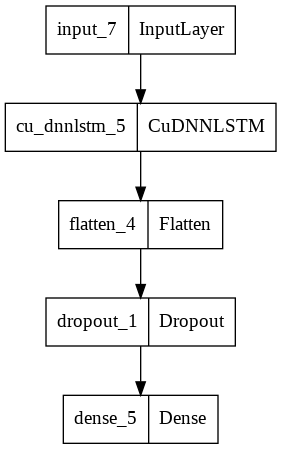

In [141]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True, 
    rankdir='TB', expand_nested=False, dpi=96
)

In [159]:
tf.keras.backend.clear_session()
!rm -rf ./logs/

In [150]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
target_train = ohe.fit_transform(y_train.values.reshape(-1,1)).toarray()
target_test = ohe.transform(y_test.values.reshape(-1,1)).toarray()

In [152]:
#to avoid the error: Creating variables on a non-first call to a function decorated with tf.function.
#reference: https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
tf.config.run_functions_eagerly(True)

In [160]:
#%load_ext tensorboard
#import datetime, os
#from tensorflow.keras.callbacks import ModelCheckpoint
filepath="weights_copy.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', verbose=1, save_best_only = True, mode='max')
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)
model.fit(x = v, y = target_train, validation_data = (w, target_test), epochs = 30, batch_size = 80,
          callbacks = [checkpoint]) #, tensorboard_callback])

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


1000/1000 [==============================] - ETA: 0s - loss: 0.1950 - auc: 0.9442

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "



Epoch 1: val_auc improved from -inf to 0.94731, saving model to weights_copy.best.hdf5
1000/1000 [==============================] - 55s 55ms/step - loss: 0.1950 - auc: 0.9442 - val_loss: 0.1897 - val_auc: 0.9473
Epoch 2/30
 999/1000 [============================>.] - ETA: 0s - loss: 0.1934 - auc: 0.9435
Epoch 2: val_auc improved from 0.94731 to 0.94841, saving model to weights_copy.best.hdf5
1000/1000 [==============================] - 55s 55ms/step - loss: 0.1934 - auc: 0.9435 - val_loss: 0.1859 - val_auc: 0.9484
Epoch 3/30
1000/1000 [==============================] - ETA: 0s - loss: 0.1943 - auc: 0.9445
Epoch 3: val_auc did not improve from 0.94841
1000/1000 [==============================] - 55s 55ms/step - loss: 0.1943 - auc: 0.9445 - val_loss: 0.1814 - val_auc: 0.9478
Epoch 4/30
 999/1000 [============================>.] - ETA: 0s - loss: 0.1925 - auc: 0.9449
Epoch 4: val_auc did not improve from 0.94841
1000/1000 [==============================] - 55s 55ms/step - loss: 0.1926 - 

Tried creating tensorboard graphs but got  - 'Function' object has no attribute '_concrete_stateful_fn'. I was unable to debug the error, I couldn't find any solution on the internet as well.

In [163]:
model.save('best_model.hdf5')

<Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 
1. Pipeline is a way to codify and automate the workflow.
2. Download the test.csv file from here <a href="https://drive.google.com/file/d/1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo/view?usp=sharing">here</a> </pre>


In [ ]:
#there is an alterante way to load files from Google drive directly to your Colab session
# you can use gdown module to import the files as follows
#for example for test.csv you can write your code as !gdown --id file_id (remove the # from next line and run it)

In [161]:
!gdown --id 1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QwjqTsqTX2vdy7fTmeXjxP3dq8IAVLpo
To: /content/test.csv
100% 62.1k/62.1k [00:00<00:00, 66.9MB/s]


In [172]:
#read the csv file
test_df = pd.read_csv('test.csv', encoding = 'utf-8')

In [173]:
test_df.head()

,Text
0,Just opened Greenies Joint Care (individually ...
1,This product rocks :) My mom was very happy w/...
2,"The product was fine, but the cost of shipping..."
3,I love this soup. It's great as part of a meal...
4,Getting ready to order again. These are great ...


<Pre>1. You have to write a function that takes the test_df,trained model and the required parameters as input. 
2. Perform all the preproceesing steps inside the function.
- Remove all the html tags
- Now do tokenization [Part 3 as mentioned above]
- Create tokens,mask array and segment array
- Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
- Print the shape of output(X_test.shape).You should get (352,768)
3. Predit the output of X_test with the neural network model which we trained earlier.

4. Return the occurences of class labels from the function.
The output should be the count of datapoints classified as 1 or 0.

</pre>

In [196]:
def remove_html(x):
  return re.sub("<.*?>", '', x)

def pipeline(X_test, filepath):
  '''
  Function takes test datapoints and the filepath where the weights of the optimal model are stored.
  Returns the no. of datapoints belonging to each class as predictions of the test datapoints.
  '''
  
  #removing html tags from the data
  X_test['Text'] = X_test['Text'].apply(remove_html)

  #creating tokens, mask and segment for test data
  test_tokens = []
  test_mask = []
  test_segment = []
  for text in X_test.values:
    tokens = tokenizer.tokenize(text[0])
    if len(tokens) > (max_seq_length-2):
      tokens = tokens[0:(max_seq_length-2)]
    tokens = ['[CLS]', *tokens, '[SEP]']
    token_length = len(tokens)
    if len(tokens) < max_seq_length:
      pad = ["[PAD]"]
      tokens.extend(pad*(max_seq_length - len(tokens)))
    tokens = np.array(tokens)
    mask = np.array([1]*token_length+ [0]*(max_seq_length - token_length))
    segment = np.array([0]*max_seq_length)
    test_tokens.append(np.array(tokenizer.convert_tokens_to_ids(tokens)))
    test_mask.append(mask)
    test_segment.append(segment)

  X_test_tokens = np.array(test_tokens)
  X_test_mask = np.array(test_mask)
  X_test_segment = np.array(test_segment)

  #getting BERT embeddings for test data
  X_test_pooled = bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])
  
  #printing the shape of the embeddings obtained
  print(X_test_pooled.shape)

  #reshaping X_test_pooled for CuDNNLSTM - as it needs 3dim input
  org_shape = X_test_pooled.shape
  X_test_pooled = X_test_pooled.reshape(org_shape[0], org_shape[1], 1)

  #model architecture
  input_layer = Input(shape = (X_train_pooled_output.shape[1],1))
  lstm_layer = CuDNNLSTM(64, return_sequences = True)(input_layer)
  flat1 = Flatten()(lstm_layer)
  dense = Dense(32,activation = 'relu', kernel_initializer = HeNormal(), kernel_regularizer = L2(0.0001))(flat1)
  dropout = Dropout(0.5)(flat1)
  output = Dense(2, activation = 'softmax')(dropout)
  model = Model(input_layer, output)
  #loading the weights of the best model we got
  model.load_weights(filepath)
  model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0006), metrics = [auc])

  preds = model.predict(X_test_pooled)
  y_pred = preds[:,1]
  print("No. of datapoints classified as belonging to class 0: ",sum(y_pred<0.5))
  print("No. of datapoints classified as belonging to class 1: ",sum(y_pred>=0.5))

  return (sum(y_pred<0.5), sum(y_pred>=0.5))
  
  

In [197]:
no_of_0, no_of_1 = pipeline(test_df, filepath)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


(352, 768)
No. of datapoints classified as belonging to class 0:  30
No. of datapoints classified as belonging to class 1:  322


## Please write your observations at the end of notebook and  explain each and every step you followed in solving this assignment.

In [207]:
from prettytable import PrettyTable


x = PrettyTable()
x.field_names = ["Features", "Model", "Epochs", "Train AUC", "Validation AUC"]
x.add_row(["BERT embeddings for text data", "CuDNNLSTM", 28, 0.9484, 0.9516])

print(x)

+-------------------------------+-----------+--------+-----------+----------------+
|            Features           |   Model   | Epochs | Train AUC | Validation AUC |
+-------------------------------+-----------+--------+-----------+----------------+
| BERT embeddings for text data | CuDNNLSTM |   28   |   0.9484  |     0.9516     |
+-------------------------------+-----------+--------+-----------+----------------+


Observations:

1. The difference between train AUC and validation AUC is low. Therefore, there is no overfit/ underfit.

2. The use of BERT embeddings enabled us to achieve a good AUC of over 95% in very less epochs even using a simple model with very less no. of trainable parameters in the order of 100,000.

3. LSTM is good with capturing patterns. BERT embeddings + a simple LSTM model like the one used here can achieve good results with low computational resuorces in less training time. Hence, NLP with transfer learning is an effective approach. 

